# Segmentation Workflow

The purpose of this jupyter notebook is to perform pre-processing, segmentation, and labeling of segmented ROIs.  

**Preprocessing** steps convert the image to grayscale and performs unsharp masking to remove varied background fluorescence.

**Segmentation** takes place using canny edge detection that is improved via binary hole filling, small object removal, and opening to remove neuronal processes



First we need to import the important packages we will use and mount the notebook to drive. This notebook uses `skimage` for image processing and thte `pyplot` module of `matplotlib` for image visualization



In [81]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import os

# mount drive- following tutorial at https://medium.com/ml-book/simplest-way-to-open-files-from-google-drive-in-google-colab-fae14810674
from google.colab import drive
drive.mount('/content/drive')
 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Next we need to load the image and convert it into grayscale

In [82]:

im_dir='drive/My Drive/CHEME 599/Project/images'; # image path to open

fname='PL01.tif'
im=plt.imread(os.path.join(im_dir, fname)); # read image 
  
from skimage import color
im=color.rgb2gray(im) 
print(im.shape)

(506, 496)


The major preprocessing step we will use is unsharp masking which is used to remove large fluctuations in background intensity across an image. This makes it much easier to differentiate neurons from general background fluorescence from neuropil


In [83]:
def unsharp_mask(im, scale):  
    from skimage.morphology import square
    from skimage.filters import rank
    from skimage.util import img_as_ubyte

    im=img_as_ubyte(im) # ensure the image is in uint8 form
    length=int((np.round(im.shape[1]/scale,0))); # set filter size to 1/ scaling factor of image size 
    selem=square(length) # create mask that is half as wide as the image rounded up
    background=1.0*rank.mean(im, selem) # generate the background image
    im_us=im-background # subtract background from main image
  # normalize the image fluoresence
    im_min=np.min(im_us)
    im_range = np.max(im_us)-im_min
    im_us = np.round(255*(im_us - im_min)/im_range, 0) # normalize
    return(im_us)

It is time to perform unsharp masking on the image. Note how much clearer cells are on the produced unsharp masked image

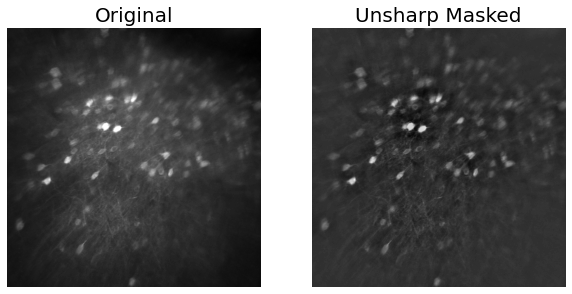

In [84]:
from skimage.exposure import equalize_hist

im_us=unsharp_mask(im,10)

fig, ax = plt.subplots(ncols=2, figsize=(10,6)) 
titles=('Original', 'Unsharp Masked')
for axi, title in zip(ax,titles):
  axi.axis('off')
  axi.set_title(title, fontsize=20)

ax[0].imshow(im, cmap='gray')
ax[1].imshow(im_us, cmap='gray');

Now it is time to segment the neurons!
We need to import some functions to do this

In [85]:
from skimage.feature import canny # smooths image before calculating edges, can remove false edges
from skimage.morphology import disk, binary_dilation, binary_erosion
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects

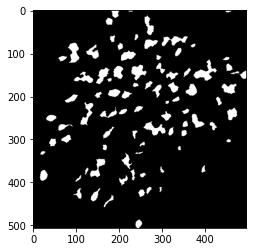

In [86]:
im2=im_us>60

from skimage.morphology import binary_closing
from skimage.filters import rank 

im2=remove_small_objects(im2,40)
im2=binary_closing(im2,disk(3))
plt.imshow(im2, cmap='gray')

Below we segment the neurons using `canny` edge detection. To fill neuronal ROIs we use the  `binary_fill_holes` function from `scipy.ndimage`. to remove bits of neuropil that were detected we use `remove_small_objects`

We visualize the binary segmented image next to the original

(-0.5, 495.5, 505.5, -0.5)

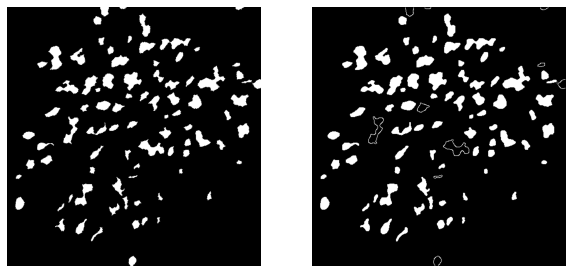

In [87]:
edges=canny(im2)
edges= binary_fill_holes(edges)
#edges=remove_small_objects(edges,30) # im, num pixels to threshold at


fig, axes=plt.subplots(ncols=2, figsize=(10,6))
axes[0].imshow(im2, cmap='gray')
axes[1].imshow(edges,cmap='gray') # pick up a lot of edges within the coins 
axes[0].axis('off')
axes[1].axis('off')

Pieces of axons/dendrites branching off the main neural body in the plane are still visualized. To remove them, we perform a binary opening and visualize the final image next to the orignal






(-0.5, 495.5, 505.5, -0.5)

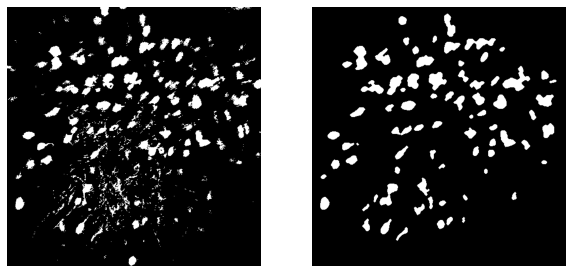

In [88]:
from skimage.morphology import binary_opening

edges=binary_opening(edges,disk(2))
fig, axes=plt.subplots(ncols=2, figsize=(10,6))
axes[0].imshow(im_us>60, cmap='gray')
axes[1].imshow(edges,cmap='gray') # pick up a lot of edges within the coins 
axes[0].axis('off')
axes[1].axis('off')

Finally, we need to separate the ROIs individually for future analysis. Below we can see the segmented neurons next to the original image. Each cell is labelled and colored individually

(-0.5, 495.5, 505.5, -0.5)

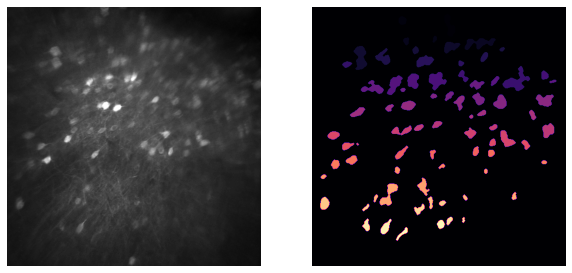

In [89]:
from scipy.ndimage import label
from skimage.color import label2rgb

labeled, _ = label(edges)

fig, axes=plt.subplots(ncols=2, figsize=(10,6))
axes[0].imshow(im, cmap='gray')
axes[1].imshow(labeled,cmap='magma') 
axes[0].axis('off')
axes[1].axis('off')


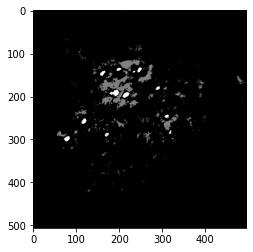

In [90]:
#watershed
markers=im_us*0;
markers[im_us>150]=2
markers[im_us<35]=1
plt.imshow(markers, cmap='gray')

(-0.5, 495.5, 505.5, -0.5)

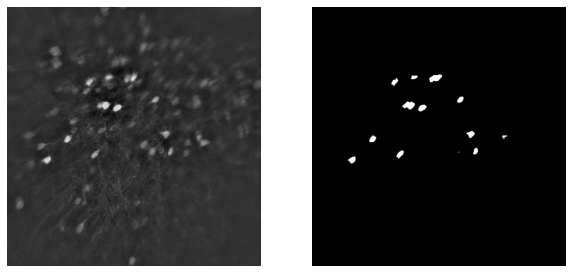

In [91]:
from skimage.morphology import watershed, disk
from skimage.util import invert, img_as_float
from skimage.filters import sobel, rank
im_us=img_as_float(im_us)
elevation_map=sobel(im_us)
#elevation_map=rank.mean(elevation_map, disk(3))
segmentation=watershed(elevation_map, markers)#(elevation map, markers)
fig, axes=plt.subplots(ncols=2, figsize=(10,6))
axes[0].imshow(im_us, cmap='gray')
axes[1].imshow(segmentation,cmap='gray') 
axes[0].axis('off')
axes[1].axis('off')

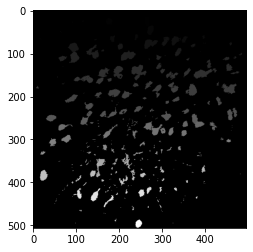

In [92]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
im3=im_us>60
distance = ndimage.distance_transform_edt(im3)#
#local_maxi = is_local_maximum(distance, image, np.ones((3, 3)))
#markers = ndimage.label(local_maxi)[0]
#labels = watershed(-distance, markers, mask=image)
localMax = peak_local_max(distance, indices=False, min_distance=10)
markers = ndimage.label(localMax)[0]
labels = watershed(-distance, markers, mask=im3)

plt.imshow(labels, cmap='gray')

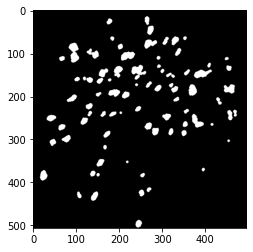

In [93]:
from skimage.morphology import binary_opening
labels=labels>0;
im4=binary_opening(labels, disk(3))
plt.imshow(im4, cmap='gray')

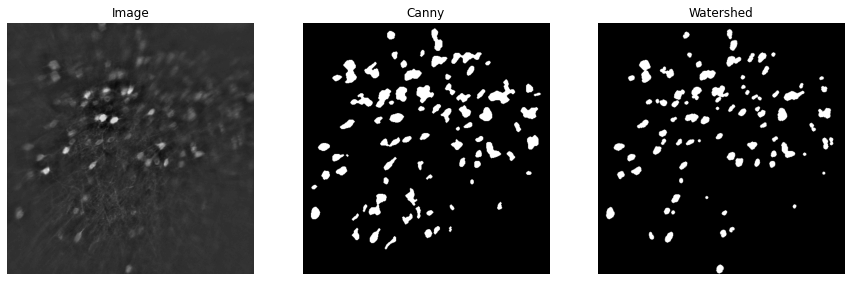

In [102]:
fig, ax=plt.subplots(ncols=3, figsize=(15,5))
ax[0].imshow(im_us, cmap='gray', vmin=0, vmax=255)
ax[0].set_title('Image')
ax[1].imshow(labeled>0,cmap='gray')
ax[1].set_title('Canny')
ax[2].imshow(im4, cmap='gray')
ax[2].set_title('Watershed')

for axi in ax:
  axi.axis('off')
